In [1]:
import os
import pickle
from itertools import product

import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
import numpy as np

from run_fl import generate_data, optimal_value, crr_cli

%load_ext autoreload
%autoreload 2

sns.set(style="whitegrid", font_scale=1.2, context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['figure.figsize'] = (8, 6)

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
.jupyter-widgets {color: #d5d5d5 !important;}
.widget-label {color: #d5d5d5 !important;}
</style>


# x_0 = 1, dim = 100, batch_size=16

In [3]:
dim = 100

In [4]:
data = generate_data(dim)
x_opt, f_opt = optimal_value(data)

# Additional functions

In [5]:
def best_result(
    alg_type,
    results_dir,
    n_comms,
    cl_lr_list=[None],
    se_lr_list=[None],
    c_0_list=[None],
    c_1_list=[None],
    cl_cl_list=[None],
):
    min_val = np.inf
    best_result = None
    is_any_result = False
    for client_lr, server_lr, c_0, c_1, client_cl in product(cl_lr_list, se_lr_list, c_0_list, c_1_list, cl_cl_list):
    # for step_size, clip_level in product(step_size_list, clip_level_list):
        if alg_type == 'l_sgd_jump':
            result_fn = f'l_sgd_jump_cl_lr_{client_lr}_c_0_{c_0}_c_1_{c_1}_{n_comms}'
        elif alg_type == 'l0l1_gd':
            result_fn = f'gd_c_0_{c_0}_c_1_{c_1}_{n_comms}'
        elif alg_type == 'l_clip_sgd':
            result_fn = f'l_clip_sgd_c_0_{c_0}_c_1_{c_1}_{n_comms}'
        elif alg_type == 'clip_fedavg':
            result_fn = f'clip_fedavg_cl_lr_{client_lr}_se_lr_{server_lr}_cl_cl_{client_cl}_{n_comms}'
        elif alg_type == 'crr_cli':
            result_fn = f'crr_cli_cl_lr_{client_lr}_se_lr_{server_lr}_c_0_{c_0}_c_1_{c_1}_{n_comms}'
        elif alg_type == 'clip_fedavg_pp':
            result_fn = f'clip_fedavg_pp_cl_lr_{client_lr}_se_lr_{server_lr}_cl_cl_{client_cl}_{n_comms}'
        else:
            raise NotImplementedError(f"{alg_type} is not implemented!")

        result_path = os.path.join(results_dir, result_fn)
        if not os.path.exists(result_path):
            continue

        with open(result_path, "rb") as f:
            result = {'loss': pickle.load(f)}
        best_result, min_val = update_best_result(
            best_result,
            min_val,
            result,
        )
        if best_result is not None:
            is_any_result = True
            if alg_type == 'l_sgd_jump':
                result['client_lr'] = client_lr
                result['c_0'] = c_0
                result['c_1'] = c_1
            elif alg_type == 'l_clip_sgd' or alg_type == 'l0l1_gd':
                result['c_0'] = c_0
                result['c_1'] = c_1
            elif alg_type == 'clip_fedavg' or alg_type == 'clip_fedavg_pp':
                result['client_lr'] = client_lr
                result['server_lr'] = server_lr
                result['client_cl'] = client_cl
            elif alg_type == 'crr_cli':
                result['client_lr'] = client_lr
                result['server_lr'] = server_lr
                result['c_0'] = c_0
                result['c_1'] = c_1

    assert is_any_result, f"There are no saved results!, {result_path}"

    return best_result


def update_best_result(best_result, min_val, result):
    mean_loss_vals = 0
    for seed in result['loss']:
        loss_val_seed = result['loss'][seed]
        last_part = loss_val_seed[-len(loss_val_seed) // 4 :]
        mean_loss_vals += np.mean(last_part)
    if mean_loss_vals < min_val:
        min_val = mean_loss_vals
        best_result = result
    return best_result, min_val

In [6]:
def plot_result(result, label, fill_between=True, ax=None, line_style=None, color=None, f_opt=None):
    seed_values = result["loss"]
    if f_opt is None:
        mean = np.mean(np.array(list(seed_values.values())), axis=0)
    else:
        mean = np.mean(np.array(list(seed_values.values())) - f_opt, axis=0)
    if fill_between:
        if f_opt is None:
            std = np.std(np.array(list(seed_values.values())), axis=0)
        else:
            std = np.std(np.array(list(seed_values.values())) - f_opt, axis=0)
    if ax is None:
        plt.plot(mean, label=label, linestyle=line_style, color=color)
        if fill_between:
            plt.fill_between(
                range(len(mean)), mean - std, mean + std, alpha=0.2, color=color
            )
    else:
        ax.plot(mean, label=label, linestyle=line_style, color=color)
        if fill_between:
            ax.fill_between(
                range(len(mean)), mean - std, mean + std, alpha=0.2, color=color
            )

In [7]:
x_0 = 1.
batch_size = 16
n_comms = 200

## L0-L1-GD

### Parameters

In [8]:
c_0_min = -10
c_0_max = 6
c_1_min = -10
c_1_max = 6

In [9]:
c_0_list = np.logspace(c_0_min, c_0_max, c_0_max - c_0_min + 1)
c_1_list = np.logspace(c_1_min, c_1_max, c_1_max - c_1_min + 1)
c_0_list, c_1_list

(array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06]),
 array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06]))

### Best result

In [10]:
l0l1gd_best_result = best_result(
    'l0l1_gd', 
    f'results/fl_fourth_order/dim_{dim}/x_0_{x_0}/gd', 
    n_comms, 
    c_0_list=c_0_list,
    c_1_list=c_1_list
)
l0l1gd_best_result['c_0'], l0l1gd_best_result['c_1']

(10000.0, 1e-10)

In [12]:
len(l0l1gd_best_result['loss'])

10

# CRR-CLI

In [18]:
n_epochs = n_comms
batch_size = 16

In [19]:
client_lr_min = -10
client_lr_max = -6
server_lr_min = -10
server_lr_max = -6
c_0_min = -10
c_0_max = 5
c_1_min = -10
c_1_max = 5

In [20]:
client_lr_list = np.logspace(client_lr_min, client_lr_max, client_lr_max - client_lr_min + 1)
server_lr_list = np.logspace(server_lr_min, server_lr_max, server_lr_max - server_lr_min + 1)
c_0_list = np.logspace(c_0_min, c_0_max, c_0_max - c_0_min + 1)
c_1_list = np.logspace(c_1_min, c_1_max, c_1_max - c_1_min + 1)
client_lr_list, server_lr_list, c_0_list, c_1_list

(array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06]),
 array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06]),
 array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
 array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]))

In [21]:
crrcli_best_result = best_result(
    'crr_cli', 
    f'results/fl_fourth_order/dim_{dim}/x_0_{x_0}/crr_cli/bs_{batch_size}', 
    n_epochs, 
    cl_lr_list=client_lr_list,
    se_lr_list=server_lr_list,
    c_0_list=c_0_list,
    c_1_list=c_1_list
)
crrcli_best_result['client_lr'], crrcli_best_result['server_lr'], crrcli_best_result['c_0'], crrcli_best_result['c_1']

(1e-10, 1e-10, 100000.0, 1e-10)

# Clip-FedAvg-PP

In [22]:
client_lr_min = -10
client_lr_max = 3
server_lr_min = -10
server_lr_max = 3
client_cl_min = 0
client_cl_max = 4

In [23]:
client_lr_list = np.logspace(client_lr_min, client_lr_max, client_lr_max - client_lr_min + 1)
server_lr_list = np.logspace(server_lr_min, server_lr_max, server_lr_max - server_lr_min + 1)
client_cl_list = np.logspace(client_cl_min, client_cl_max, client_cl_max - client_cl_min + 1)
client_lr_list, server_lr_list, client_cl_list

(array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]))

In [24]:
n_local_steps = 10

In [25]:
cfedavgpp_best_result = best_result(
    'clip_fedavg_pp', 
    f'results/fl_fourth_order/dim_{dim}/x_0_{x_0}/tau_{n_local_steps}/bs_{batch_size}', 
    n_epochs, 
    cl_lr_list=client_lr_list,
    se_lr_list=server_lr_list,
    cl_cl_list=client_cl_list
)
cfedavgpp_best_result['client_lr'], cfedavgpp_best_result['server_lr'], cfedavgpp_best_result['client_cl']

(1e-06, 10.0, 1.0)

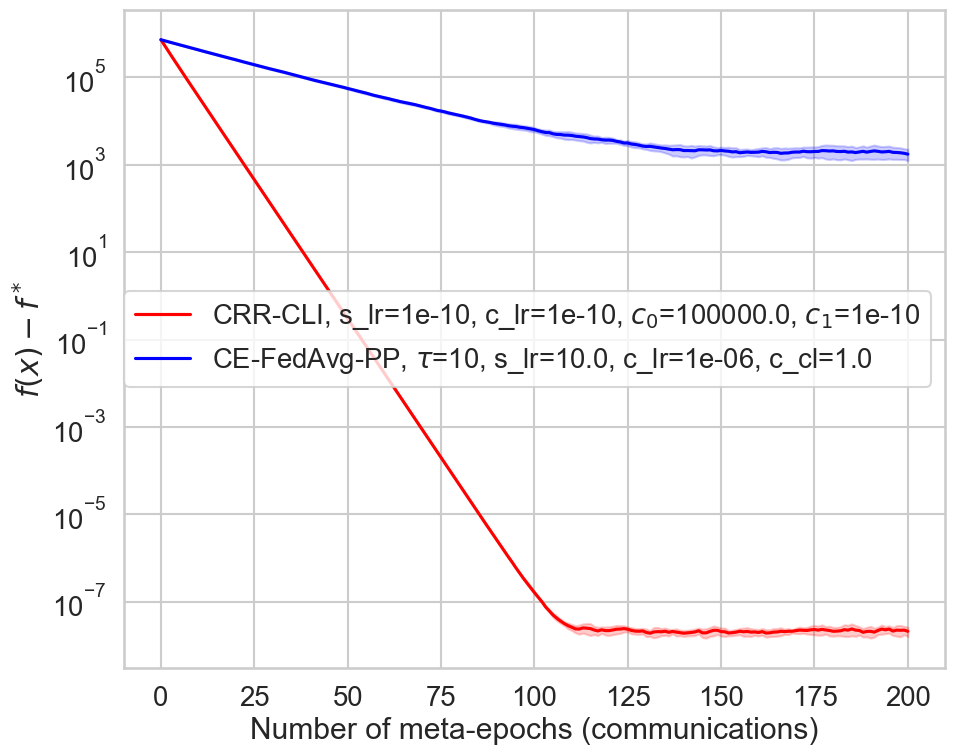

In [26]:
fig = plt.figure(figsize=(10, 8))
crrcli_label = fr'CRR-CLI, s_lr={crrcli_best_result['server_lr']}, c_lr={crrcli_best_result['client_lr']}, $c_0$={crrcli_best_result['c_0']}, $c_1$={crrcli_best_result['c_1']}'
plot_result(crrcli_best_result, crrcli_label, f_opt=f_opt, color='red')
cfedavgpp_label = fr'CE-FedAvg-PP, $\tau$={n_local_steps}, s_lr={cfedavgpp_best_result['server_lr']}, c_lr={cfedavgpp_best_result['client_lr']}, c_cl={cfedavgpp_best_result['client_cl']}'
plot_result(cfedavgpp_best_result, cfedavgpp_label, f_opt=f_opt, color='blue')
# l0l1gd_lbl = fr'L0-L1-GD, c_0={l0l1gd_best_result['c_0']}, c_1={l0l1gd_best_result['c_1']}'
# plot_result(l0l1gd_best_result, l0l1gd_lbl, f_opt=f_opt, color='green')
plt.legend()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title(fr'x_0={x_0}, batch size={batch_size}, $\tau$={n_local_steps}')
plt.ylabel(r'$f(x) - f^*$')
plt.xlabel('Number of meta-epochs (communications)')
plt.yscale('log')
plt.tight_layout()
plt.savefig('plots/crr_cli/fourth_order.png')

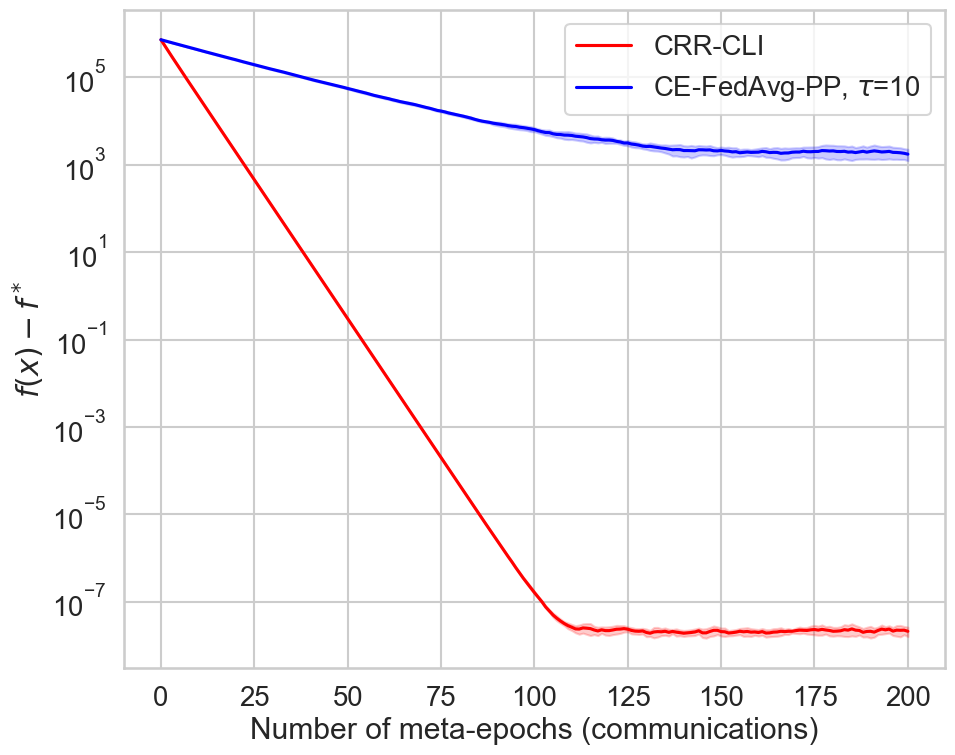

In [28]:
fig = plt.figure(figsize=(10, 8))
crrcli_label = fr'CRR-CLI'
plot_result(crrcli_best_result, crrcli_label, f_opt=f_opt, color='red')
cfedavgpp_label = fr'CE-FedAvg-PP, $\tau$={n_local_steps}'
plot_result(cfedavgpp_best_result, cfedavgpp_label, f_opt=f_opt, color='blue')
# l0l1gd_lbl = fr'L0-L1-GD, c_0={l0l1gd_best_result['c_0']}, c_1={l0l1gd_best_result['c_1']}'
# plot_result(l0l1gd_best_result, l0l1gd_lbl, f_opt=f_opt, color='green')
plt.legend()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title(fr'x_0={x_0}, batch size={batch_size}, $\tau$={n_local_steps}')
plt.ylabel(r'$f(x) - f^*$')
plt.xlabel('Number of meta-epochs (communications)')
plt.yscale('log')
plt.tight_layout()
plt.savefig('plots/crr_cli/fourth_order_no_params.png')